In [2]:
from pathlib import Path
def read_file(file_name):
    path = Path(file_name)
    if not path.exists():
        print("File not found")
        return None

    text = path.read_text(encoding="utf-8", errors="ignore")
    lines = text.splitlines()
    print("Total lines in file:", len(lines))
    return lines

In [19]:
def get_instance_info(lines, instance_name):
    start = None
    for i, line in enumerate(lines):
        if line.strip().lower() == f"instance {instance_name.lower()}":
            start = i
            break

    if start is None:
        print("Instance not found")
        return None, None, None

    j = start + 1
    while j < len(lines):
        parts = lines[j].split()
        if len(parts) >= 2 and parts[0].isdigit():
            n_jobs = int(parts[0])
            n_machines = int(parts[1])
            break
        j += 1

    return start, n_jobs, n_machines
    print("Instance:", instance_name)
    print("Jobs:", n_jobs, "Machines:", n_machines)

In [4]:
def extract_jobs(lines, start, n_jobs):
    jobs = []
    j = start + 1
    # move to the line that has job/machine numbers
    while j < len(lines):
        parts = lines[j].split()
        if len(parts) >= 2 and parts[0].isdigit():
            break
        j += 1

    j += 1  # move to first job line
    count = 0
    while count < n_jobs and j < len(lines):
        parts = lines[j].split()
        # only process line if it starts with a number
        if len(parts) > 0 and parts[0].isdigit():
            nums = list(map(int, parts))
            job = []

            for k in range(0, len(nums), 2):
                job.append((nums[k], nums[k+1]))
            jobs.append(job)
            count += 1
        j += 1
    return jobs    
    print("Loaded", len(jobs), "jobs")

In [5]:
lines = read_file("jobshop.txt")
start, n_jobs, n_machines = get_instance_info(lines, "ft06")
jobs = extract_jobs(lines, start, n_jobs)
print(jobs[0])

Total lines in file: 2243
Instance: ft06
Jobs: 6 Machines: 6
[(2, 1), (0, 3), (1, 6), (3, 7), (5, 3), (4, 6)]


In [6]:
import random
import math
def create_individual(jobs):
    parents = []
    for i in range(len(jobs)):
        parents += [i] * len(jobs[i])
    random.shuffle(parents)
    sigma = random.uniform(0.1, 0.4)
    return [parents, sigma]

In [7]:
def mutate(ind):
    parents, sigma = ind
    tau = 0.2
    sigma = sigma * math.exp(tau * random.gauss(0,1))
    if sigma < 0.05:
        sigma = 0.05
    if sigma > 1:
        sigma = 1
        
    n_swaps = int(len(parents) * sigma)
    for _ in range(n_swaps):
        a = random.randint(0, len(parents)-1)
        b = random.randint(0, len(parents)-1)
        parents[a], parents[b] = parents[b], parents[a]

    return [parents, sigma]

In [8]:
def makespan(ind, jobs):
    parents = ind[0]
    job_next = [0]*len(jobs)
    job_time = [0]*len(jobs)
    machine_time = {}

    for j in parents:
        op = job_next[j]
        m, t = jobs[j][op]
        start = max(job_time[j], machine_time.get(m,0))
        finish = start + t
        job_time[j] = finish
        machine_time[m] = finish
        job_next[j] += 1

    return max(job_time)

In [9]:
def ES_self_adaptive(jobs, pop_size=10, iters=100):
    pop = [create_individual(jobs) for _ in range(pop_size)]

    for it in range(iters):
        children = []
        for ind in pop:
            child = mutate([ind[0].copy(), ind[1]])
            children.append(child)
            
        all_pop = pop + children
        all_pop.sort(key=lambda x: makespan(x, jobs))
        pop = all_pop[:pop_size]
        best_makespan = makespan(pop[0], jobs)
        print("Iter", it, "Best makespan:", best_makespan, "sigma:", round(pop[0][1],3))

    return pop[0]

In [14]:
file = "jobshop.txt"
instance = "ft10"  # change instance here

lines = read_file(file)
if lines:
    start, n_jobs, n_machines = get_instance_info(lines, instance)
    if start is not None:
        jobs = extract_jobs(lines, start, n_jobs)
        # Display jobs
        for i, job in enumerate(jobs):
            print(f"Job {i}: {job}")

        print("\nRunning Evolution Strategies...\n")
        best = ES_self_adaptive(jobs, pop_size=250, iters=100)
        print("\nBest Makespan:", makespan(best, jobs))
        print("Best Sigma:", best[1])

Total lines in file: 2243
Instance: ft10
Jobs: 10 Machines: 10
Job 0: [(0, 29), (1, 78), (2, 9), (3, 36), (4, 49), (5, 11), (6, 62), (7, 56), (8, 44), (9, 21)]
Job 1: [(0, 43), (2, 90), (4, 75), (9, 11), (3, 69), (1, 28), (6, 46), (5, 46), (7, 72), (8, 30)]
Job 2: [(1, 91), (0, 85), (3, 39), (2, 74), (8, 90), (5, 10), (7, 12), (6, 89), (9, 45), (4, 33)]
Job 3: [(1, 81), (2, 95), (0, 71), (4, 99), (6, 9), (8, 52), (7, 85), (3, 98), (9, 22), (5, 43)]
Job 4: [(2, 14), (0, 6), (1, 22), (5, 61), (3, 26), (4, 69), (8, 21), (7, 49), (9, 72), (6, 53)]
Job 5: [(2, 84), (1, 2), (5, 52), (3, 95), (8, 48), (9, 72), (0, 47), (6, 65), (4, 6), (7, 25)]
Job 6: [(1, 46), (0, 37), (3, 61), (2, 13), (6, 32), (5, 21), (9, 32), (8, 89), (7, 30), (4, 55)]
Job 7: [(2, 31), (0, 86), (1, 46), (5, 74), (4, 32), (6, 88), (8, 19), (9, 48), (7, 36), (3, 79)]
Job 8: [(0, 76), (1, 69), (3, 76), (5, 51), (2, 85), (9, 11), (6, 40), (7, 89), (4, 26), (8, 74)]
Job 9: [(1, 85), (0, 13), (2, 61), (6, 7), (8, 64), (9, 76),

C:\Users\smwas\AppData\Local\Temp\ipykernel_19544\1136720695.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(jobs))


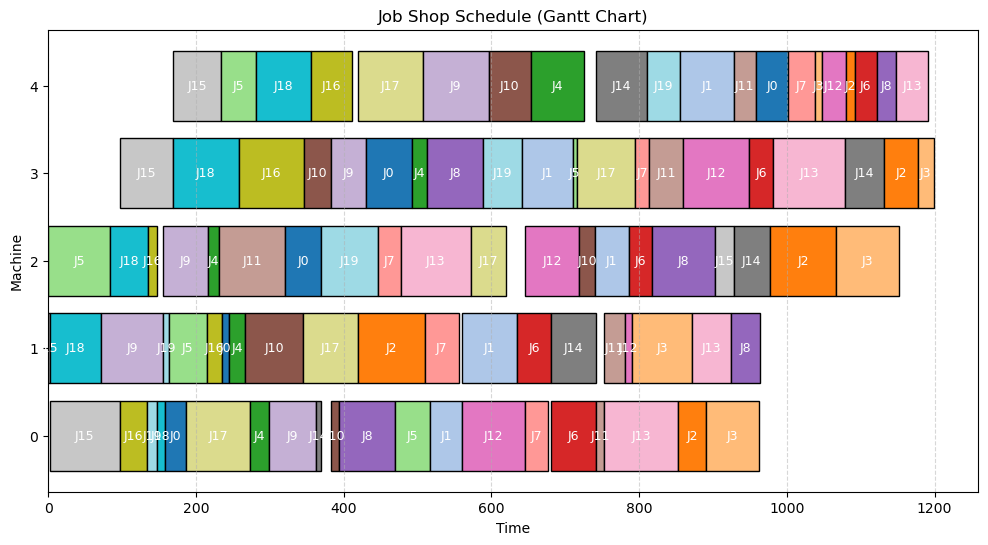


Best Makespan: 1199
Best Sigma: 0.05


In [13]:
import matplotlib.pyplot as plt
def plot_schedule(ind, jobs):
    parents = ind[0]
    job_next = [0]*len(jobs)
    job_time = [0]*len(jobs)
    machine_time = {}
    # list of (machine, job, start, finish)
    schedule = []  
    for j in parents:
        op = job_next[j]
        m, t = jobs[j][op]
        start = max(job_time[j], machine_time.get(m,0))
        finish = start + t
        schedule.append((m, j, start, finish))
        job_time[j] = finish
        machine_time[m] = finish
        job_next[j] += 1
    
    plt.figure(figsize=(12,6))
    colors = plt.cm.get_cmap('tab20', len(jobs))
    for m, j, start, finish in schedule:
        plt.barh(y=m, width=finish-start, left=start, height=0.8, color=colors(j), edgecolor='black')
        plt.text(x=start + (finish-start)/2, y=m, s=f"J{j}", va='center', ha='center', color='white', fontsize=9)
    
    plt.xlabel("Time")
    plt.ylabel("Machine")
    plt.title("Job Shop Schedule (Gantt Chart)")
    plt.yticks(range(max([m for m,_,_,_ in schedule])+1))
    plt.grid(True, axis='x', linestyle='--', alpha=0.5)
    plt.show()

plot_schedule(best, jobs)
print("\nBest Makespan:", makespan(best, jobs))
print("Best Sigma:", best[1])